# Keras InceptionV3 Feature Extraction #

### Import necessary packages ###

In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os

### Define the Feature Extraction Function ###

In [14]:
def extract_features(model, folder_path):
    # Get a list of all image files in the folder
    img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Use list comprehension to process images and extract features
    features = []
    for img_path in img_paths:
        try:
            img = image.load_img(img_path, target_size=model.input_shape[1:3])
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array)
            features.append(feature)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    # Stack the extracted features into a single NumPy array
    features = np.vstack(features)

    return features

### Load the pre-trained InceptionV3 model with top (fully connected) layers ###

In [15]:
base_model = InceptionV3(weights='imagenet', include_top=True, input_shape=(299, 299, 3)) # Adjust input_shape accordingly

### Create a new model that includes only the convolutional base of InceptionV3 ###

In [16]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

### Specify folder paths for ASD and non-ASD child face image sets ###

In [17]:
asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD'
non_asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD'

### Extract features for ASD child faces ###

In [18]:
asd_features = extract_features(model, asd_folder_path)

1/1 [==============================] - 0s 54ms/step


### Extract features for non-ASD child faces ###

In [19]:
non_asd_features = extract_features(model, non_asd_folder_path)

1/1 [==============================] - 0s 62ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/child-1617.png: cannot identify image file <_io.BytesIO object at 0x2acb555e0>
1/1 [==============================] - 0s 72ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/additional1178.png: cannot identify image file <_io.BytesIO object at 0x2e46be0e0>
1/1 [==============================] - 0s 67ms/step


### Save the extracted features for later use in training ###

In [20]:
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/asd_features.npy', asd_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/non_asd_features.npy', non_asd_features)

# Model Training InceptionV3 #

### Import necessary packages ###

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

#### Load the extracted features for ASD and non-ASD child faces ####

In [24]:
asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/asd_features.npy')
non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/non_asd_features.npy')

### Create labels for ASD (1) and non-ASD (0) samples ###

In [25]:
asd_labels = np.ones(asd_features.shape[0])
non_asd_labels = np.zeros(non_asd_features.shape[0])

### Concatenate features and labels ###

In [26]:
X = np.concatenate([asd_features, non_asd_features], axis=0)
y = np.concatenate([asd_labels, non_asd_labels])

### Split the data into training and testing sets ###

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build a simple neural network ###

In [28]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### Compile the model ###

In [29]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Train the model ###

In [30]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
250/250 [==============================] - 1s 2ms/step - loss: 0.2930 - accuracy: 0.8881 - val_loss: 0.2865 - val_accuracy: 0.8798
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.2340 - accuracy: 0.9058 - val_loss: 0.2142 - val_accuracy: 0.9133
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.2189 - accuracy: 0.9148 - val_loss: 0.2218 - val_accuracy: 0.9088
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.2104 - accuracy: 0.9149 - val_loss: 0.1936 - val_accuracy: 0.9238
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.2037 - accuracy: 0.9202 - val_loss: 0.1863 - val_accuracy: 0.9279
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1966 - accuracy: 0.9261 - val_loss: 0.1886 - val_accuracy: 0.9233
Epoch 7/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1844 - accuracy: 0.9265 - val_loss: 0.1810 - val_accuracy: 0.9248

### Evaluate the model on the test set ###

In [31]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

63/63 [==============================] - 0s 528us/step - loss: 0.3293 - accuracy: 0.9379
Test Accuracy: 0.9378757476806641


### Save the model for later use ###

In [32]:
model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/InceptionV3Model.h5')

### Prediction ###

In [33]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype('int32')

63/63 [==============================] - 0s 483us/step


### Classification report ###

In [34]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      1724
         1.0       0.85      0.66      0.74       272

    accuracy                           0.94      1996
   macro avg       0.90      0.82      0.85      1996
weighted avg       0.93      0.94      0.93      1996


### Confusion matrix ###

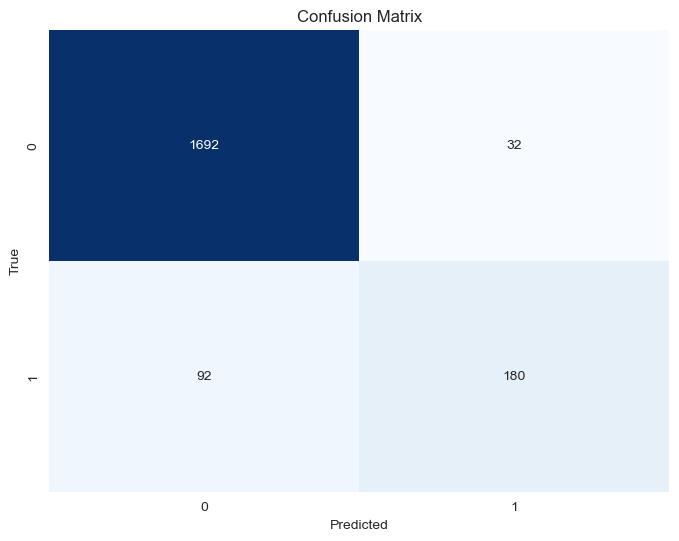

In [35]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Plot training history ###

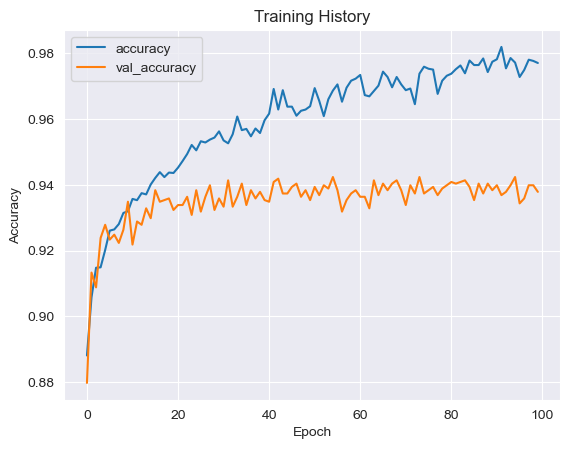

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()

# Keras InceptionV3 Prediction #

### Import Libraries ###

In [42]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import load_model

### Defining Paths and target size ###

In [43]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/InceptionV3Model.h5'
target_size = (299, 299)

#### Load Pre-trained VGG16 Model and Create a New Model ####

In [44]:
# Load the pre-trained ResNet50 model
base_model = InceptionV3(weights='imagenet', include_top=True)

# Create a new model that takes the input of ResNet50 and outputs the desired layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

### Process the input image ###

In [45]:
# Process the input image
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

# Extract features using the full ResNet50 model
features = model.predict(img) # Use the new model

1/1 [==============================] - 1s 1s/step


### Reshape Features and Load Trained Model ###

In [46]:
# Reshape features to match the expected input shape of trained_model
features_reshaped = np.reshape(features, (1, 2048 )) # Reshape to (1, 7, 7, 512)

# Load the trained model
trained_model = load_model(model_path)

### Predict ASD probability using the trained model and extracted features ###

In [47]:
# Predict ASD probability using the trained model and extracted features
prediction = trained_model.predict(features_reshaped)[0][0] # Access the first element for ASD probability
print("prediction: ", prediction)
print("prediction: {:.5f}".format(prediction))

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


1/1 [==============================] - 0s 33ms/step
prediction:  0.9999998
prediction: 1.00000
Predicted probability: 1.00
Predicted ASD with probability: 1.00


# XAI LIME #

### Import necessary libraries ###

In [59]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense
from lime.lime_image import LimeImageExplainer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model, load_model

### Provide the path to the image file ###

In [60]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path

### Provide the model path ###

In [61]:
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/InceptionV3Model.h5'
target_size = (299, 299)

### Load the pre-trained InceptionV3 model ###


In [62]:
base_model = InceptionV3(weights='imagenet', include_top=True)

### Take the output of the base model up to the last convolutional layer ###

In [63]:
x = base_model.get_layer('avg_pool').output

### Add a new dense layer for output ###

In [64]:
x = Dense(2048, activation='relu')(x)
x = Reshape((1, 1, 2048))(x) # Add this line to reshape the output of GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
prediction = Dense(1, activation='sigmoid')(x)

### Create a new model that takes the input of ResNet50 and outputs the desired layer ###

In [65]:
model = Model(inputs=base_model.input, outputs=prediction)

### Preprocess the image for the explainer by dividing pixel values by 255 ###

In [66]:
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

### Preprocess the image for the explainer by dividing pixel values by 255 ###

In [67]:
img_scaled = img / 255.0

### Predict ASD probability using the trained model and extracted features ###

1/1 [==============================] - 1s 945ms/step
prediction: 0.52164
Predicted probability: 0.52
Predicted ASD with probability: 0.52


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 428ms/step


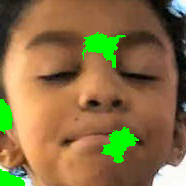

In [68]:
prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
print("prediction: {:.5f}".format(prediction))

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    explainer = LimeImageExplainer()

    # Generate an explanation for the prediction using the explainer object
    explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)

    # Visualize the explanation using matplotlib
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Resize the explanation mask to match the original image dimensions
    mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

    # Convert the mask to the original image mode
    original_image = Image.open(input_image_path)
    #original_image = original_image.convert("L")  # Convert the original image to grayscale
    original_width, original_height = original_image.size
    original_mode = original_image.mode

    # Overlay the explanation mask on the original image
    mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    original_image = np.array(original_image)
    original_image[mask > 0.5] = (0, 255, 0)



    # Display the original image with the explanation mask
    display(Image.fromarray(original_image))

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


1/1 [==============================] - 0s 412ms/step
prediction: 0.50911
Predicted probability: 0.51
Predicted ASD with probability: 0.51


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 424ms/step


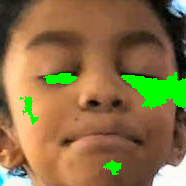

In [12]:
# import cv2
# import numpy as np
# from PIL import Image
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense
# from lime.lime_image import LimeImageExplainer
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet_v2 import preprocess_input
# from tensorflow.keras.models import Model, load_model
# 
# # Define paths
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/InceptionV3Model.h5'
# target_size = (299, 299)
# 
# # Load the pre-trained ResNet50 model
# base_model = InceptionV3(weights='imagenet', include_top=True)
# 
# x = base_model.get_layer('avg_pool').output
# x = Dense(2048, activation='relu')(x)
# x = Reshape((1, 1, 2048))(x) # Add this line to reshape the output of GlobalAveragePooling2D
# x = GlobalAveragePooling2D()(x)
# prediction = Dense(1, activation='sigmoid')(x)
# 
# # Create a new model that takes the input of ResNet50 and outputs the desired layer
# model = Model(inputs=base_model.input, outputs=prediction)
# 
# # Process the input image
# img = cv2.imread(input_image_path)
# img = cv2.resize(img, target_size)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)
# 
# img_scaled = img / 255.0
# 
# # Predict ASD probability using the trained model and extracted features
# prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
# print("prediction: {:.5f}".format(prediction))
# 
# rounded_prediction = round(prediction, 2)
# print(f"Predicted probability: {rounded_prediction:.2f}")
# 
# if rounded_prediction > 0.5:
#     print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# 
#     explainer = LimeImageExplainer()
# 
#     # Generate an explanation for the prediction using the explainer object
#     explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)
# 
#     # Visualize the explanation using matplotlib
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
# 
#     # Resize the explanation mask to match the original image dimensions
#     mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)
# 
#     # Convert the mask to the original image mode
#     original_image = Image.open(input_image_path)
#     #original_image = original_image.convert("L")  # Convert the original image to grayscale
#     original_width, original_height = original_image.size
#     original_mode = original_image.mode
# 
#     # Overlay the explanation mask on the original image
#     mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
#     original_image = np.array(original_image)
#     original_image[mask > 0.5] = (0, 255, 0)
# 
# 
# 
#     # Display the original image with the explanation mask
#     display(Image.fromarray(original_image))
# 
# else:
#     print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


In [21]:
# ## Feature Extract ##
# 
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.inception_v3 import preprocess_input
# from tensorflow.keras.models import Model
# import numpy as np
# import os
# 
# def extract_features(model, folder_path):
#     # Get a list of all image files in the folder
#     img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
# 
#     # Use list comprehension to process images and extract features
#     features = []
#     for img_path in img_paths:
#         try:
#             img = image.load_img(img_path, target_size=model.input_shape[1:3])
#             img_array = image.img_to_array(img)
#             img_array = np.expand_dims(img_array, axis=0)
#             img_array = preprocess_input(img_array)
#             feature = model.predict(img_array)
#             features.append(feature)
#         except Exception as e:
#             print(f"Error processing image {img_path}: {e}")
# 
#     # Stack the extracted features into a single NumPy array
#     features = np.vstack(features)
# 
#     return features
# 
# # Load the pre-trained InceptionV3 model with top (fully connected) layers
# base_model = InceptionV3(weights='imagenet', include_top=True, input_shape=(299, 299, 3)) # Adjust input_shape accordingly
# 
# # Create a new model that includes only the convolutional base of InceptionV3
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
# 
# # Specify folder paths for ASD and non-ASD child face image sets
# asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD'
# non_asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD'
# 
# # Extract features for ASD child faces
# asd_features = extract_features(model, asd_folder_path)
# 
# # Extract features for non-ASD child faces
# non_asd_features = extract_features(model, non_asd_folder_path)
# 
# # Save the extracted features for later use in training
# np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/asd_features.npy', asd_features)
# np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/non_asd_features.npy', non_asd_features)


1/1 [==============================] - 0s 53ms/step



KeyboardInterrupt



In [ ]:
# ## Model Training ##
# 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# import numpy as np
# 
# # Load the extracted features
# asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/asd_features.npy')
# non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/non_asd_features.npy')
# 
# # Create labels for ASD (1) and non-ASD (0) samples
# asd_labels = np.ones(asd_features.shape[0])
# non_asd_labels = np.zeros(non_asd_features.shape[0])
# 
# # Concatenate features and labels
# X = np.concatenate([asd_features, non_asd_features], axis=0)
# y = np.concatenate([asd_labels, non_asd_labels])
# 
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 
# # Build a simple neural network
# model = Sequential()
# model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# 
# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# 
# # Train the model
# model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# 
# # Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy}')
# 
# # Save the model for later use
# model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/InceptionV3Model.h5')


In [ ]:
# ## Prediction ##
# import cv2
# import numpy as np
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet_v2 import preprocess_input
# from tensorflow.keras.models import Model, load_model
# 
# # Define paths
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
# model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/InceptionV3/InceptionV3Model.h5'
# target_size = (299, 299)
# 
# # Load the pre-trained ResNet50 model
# base_model = InceptionV3(weights='imagenet', include_top=True)
# 
# # Create a new model that takes the input of ResNet50 and outputs the desired layer
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
# 
# # Process the input image
# img = cv2.imread(input_image_path)
# img = cv2.resize(img, target_size)
# img = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
# 
# # Extract features using the full ResNet50 model
# features = model.predict(img) # Use the new model
# 
# # Reshape features to match the expected input shape of trained_model
# features_reshaped = np.reshape(features, (1, 2048 )) # Reshape to (1, 7, 7, 512)
# 
# # Load the trained model
# trained_model = load_model(model_path)
# 
# # Predict ASD probability using the trained model and extracted features
# prediction = trained_model.predict(features_reshaped)[0][0] # Access the first element for ASD probability
# print("prediction: ", prediction)
# print("prediction: {:.5f}".format(prediction))
# 
# rounded_prediction = round(prediction, 2)
# print(f"Predicted probability: {rounded_prediction:.2f}")
# 
# if rounded_prediction > 0.5:
#     print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
# else:
#     print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
